In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as stats
from datetime import datetime

In [7]:
def stock_monte_carlo(start_price, days, mu, sigma):
    price_path = np.zeros(days)
    price_path[0] = start_price

    daily_returns = np.random.normal(mu, sigma, days - 1)

    for t in range(1, days):
        price_path[t] = price_path[t-1] * np.exp(daily_returns[t-1])

    return price_path

def backtest_monte_carlo(ticker, history_end_date, simulation_end_date, num_simulations, time_horizon, history_start_date: str = '1900-01-01'):
    history_data = yf.download(ticker, start = history_start_date, end=history_end_date)
    if history_data.empty:
        print(f"Error: No historical data found for {ticker} up to {history_end_date}.")
        return

    actual_data = yf.download(ticker, start=history_end_date, end=simulation_end_date)
    if actual_data.empty:
        print(f"Error: No actual data found for comparison between {history_end_date} and {simulation_end_date}.")
        return

    log_returns = np.log(1 + history_data['Close'].pct_change())
    start_price = history_data.iloc[-1]['Close']
    mu = log_returns.mean()
    sigma = log_returns.std()

    simulations = np.zeros(num_simulations)
    for run in range(num_simulations):
        price_path = np.zeros(time_horizon)
        price_path[0] = start_price
        daily_returns = np.random.normal(mu, sigma, time_horizon - 1)
        for t in range(1, time_horizon):
            price_path[t] = price_path[t-1] * np.exp(daily_returns[t-1])
        simulations[run] = price_path[-1]

    actual_price = actual_data['Close'].iloc[-1]
    if isinstance(actual_price, pd.Series):
        actual_price = actual_price.item()
    mean_final_price = simulations.mean()
    lower_bound = np.percentile(simulations, 2.5)
    upper_bound = np.percentile(simulations, 97.5)

    is_accurate = 'Yes' if lower_bound <= actual_price <= upper_bound else 'No'

    print("\n--- Backtesting Results ---")
    print(f"Simulated stock: {ticker}")
    print(f"Simulation Period: {history_end_date} to {simulation_end_date}")
    print(f"Actual End Price: ${actual_price:.2f}")
    print(f"Simulated Mean Final Price: ${mean_final_price:.2f}")
    print(f"95% Confidence Interval: [${lower_bound:.2f}, ${upper_bound:.2f}]")
    print(f"Did the actual price fall within the 95% CI? {is_accurate}")

    plt.figure(figsize=(10, 6))
    plt.hist(simulations, bins=100, label='Simulated Prices')
    plt.axvline(actual_price, color='red', linestyle='dashed', linewidth=2, label=f'Actual End Price: ${actual_price:.2f}')
    plt.axvline(mean_final_price, color='green', linestyle='dashed', linewidth=2, label=f'Mean Simulated Price: ${mean_final_price:.2f}')
    plt.title('Monte Carlo Simulation Backtest', fontsize=16)
    plt.xlabel('Final Stock Price ($)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def sensitivity_analysis(ticker, end_date, num_simulations, time_horizon, volatility_multiplier):
    try:
        data = yf.download(ticker, start='2023-04-01', end=end_date)
        if data.empty:
            print(f"Error: No data found for ticker {ticker} up to {end_date}.")
            return
    except Exception as e:
        print(f"Error downloading data: {e}")
        return

    log_returns = np.log(1 + data['Close'].pct_change())
    start_price = float(data.iloc[-1]['Close'])
    mu = log_returns.mean()
    sigma = log_returns.std() * volatility_multiplier

    simulations = np.zeros(num_simulations)
    for run in range(num_simulations):
        price_path = np.zeros(time_horizon)
        price_path[0] = start_price
        daily_returns = np.random.normal(mu, sigma, time_horizon - 1)
        for t in range(1, time_horizon):
            price_path[t] = price_path[t-1] * np.exp(daily_returns[t-1])
        simulations[run] = price_path[-1]

    mean_final_price = simulations.mean()

    print(f"\n--- Sensitivity Analysis with Volatility Multiplier {volatility_multiplier:.2f} ---")
    print(f"Start Price: ${start_price:.2f}")
    print(f"Mean Final Price: ${mean_final_price:.2f}")

    plt.figure(figsize=(10, 6))
    plt.hist(simulations, bins=100)
    plt.title(f'Sensitivity Analysis: Volatility Multiplier {volatility_multiplier:.2f}', fontsize=16)
    plt.xlabel('Final Stock Price ($)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.axvline(start_price, color='red', linestyle='dashed', linewidth=2, label=f'Start Price: ${start_price:.2f}')
    plt.axvline(mean_final_price, color='green', linestyle='dashed', linewidth=2, label=f'Mean Simulated Price: ${mean_final_price:.2f}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
tickers = ['GOOG']
end_date = '2024-03-31'
data = yf.download(tickers, start='2023-04-01', end=end_date)

/tmp/ipython-input-2606280382.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2023-04-01', end=end_date)
[*********************100%***********************]  1 of 1 completed


In [9]:
goog_data = data['Close']['GOOG']

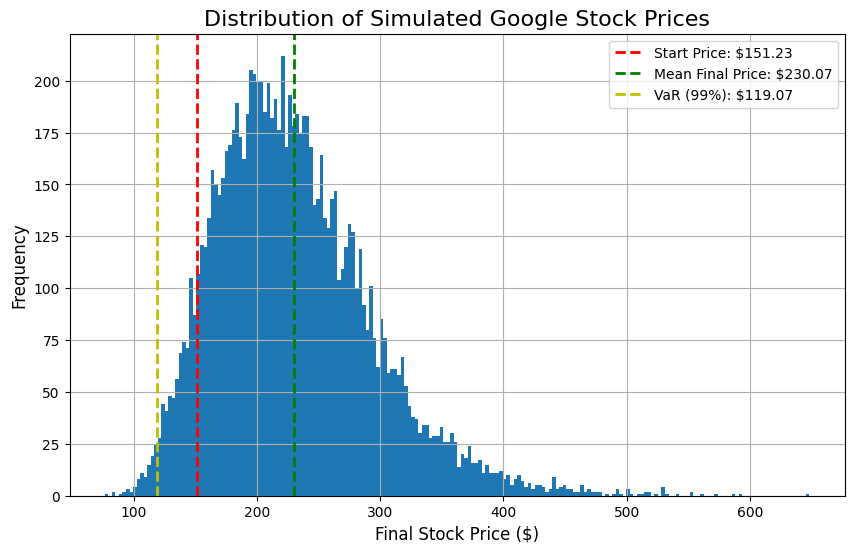

--- Simulation Results ---
Start Price: $151.23
Mean Final Price after 252 days: $230.07
Value at Risk (99%): $119.07


In [10]:
log_returns = np.log(1 + goog_data.pct_change())
mu = log_returns.mean()
sigma = log_returns.std()
start_price = goog_data.iloc[-1]
num_simulations = 10000
time_horizon = 252

simulations = np.zeros(num_simulations)
for run in range(num_simulations):
    simulations[run] = stock_monte_carlo(start_price, time_horizon, mu, sigma)[-1]

mean_final_price = simulations.mean()
var_99 = np.percentile(simulations, 1)

plt.figure(figsize=(10, 6))
plt.hist(simulations, bins=200)
plt.title('Distribution of Simulated Google Stock Prices', fontsize=16)
plt.xlabel('Final Stock Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(start_price, color='r', linestyle='dashed', linewidth=2, label=f'Start Price: ${start_price:.2f}')
plt.axvline(mean_final_price, color='g', linestyle='dashed', linewidth=2, label=f'Mean Final Price: ${mean_final_price:.2f}')
plt.axvline(var_99, color='y', linestyle='dashed', linewidth=2, label=f'VaR (99%): ${var_99:.2f}')
plt.legend()
plt.grid(True)
plt.show()

print(f"--- Simulation Results ---")
print(f"Start Price: ${start_price:.2f}")
print(f"Mean Final Price after {time_horizon} days: ${mean_final_price:.2f}")
print(f"Value at Risk (99%): ${var_99:.2f}")


/tmp/ipython-input-515277306.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  history_data = yf.download(ticker, start = history_start_date, end=history_end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-515277306.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  actual_data = yf.download(ticker, start=history_end_date, end=simulation_end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-515277306.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_path[0] = start_price



--- Backtesting Results ---
Simulated stock: GOOG
Simulation Period: 2023-04-01 to 2024-03-31
Actual End Price: $151.23
Simulated Mean Final Price: $107.18
95% Confidence Interval: [$53.53, $193.26]
Did the actual price fall within the 95% CI? Yes


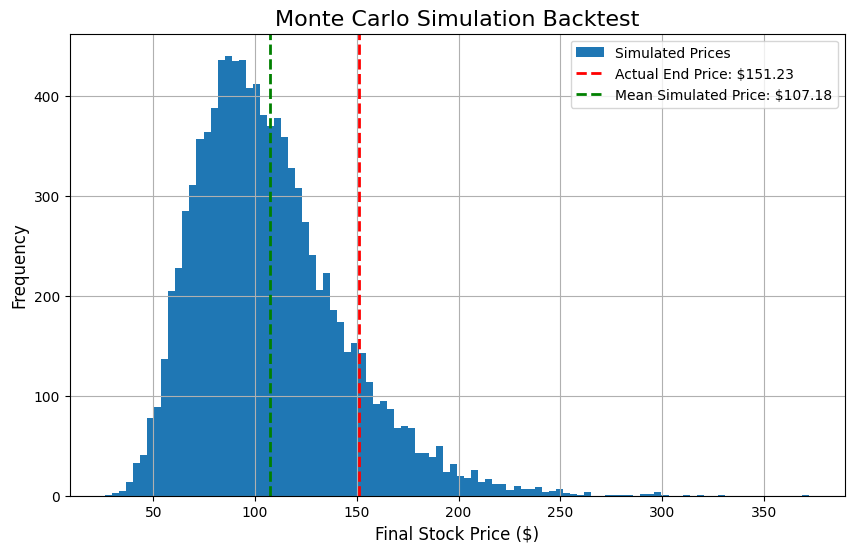

In [11]:
backtest_monte_carlo('GOOG', '2023-04-01', '2024-03-31', num_simulations=10000, time_horizon=252,history_start_date='2021-04-01')


/tmp/ipython-input-515277306.py:67: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2023-04-01', end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-515277306.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  start_price = float(data.iloc[-1]['Close'])



--- Sensitivity Analysis with Volatility Multiplier 1.10 ---
Start Price: $151.23
Mean Final Price: $231.92


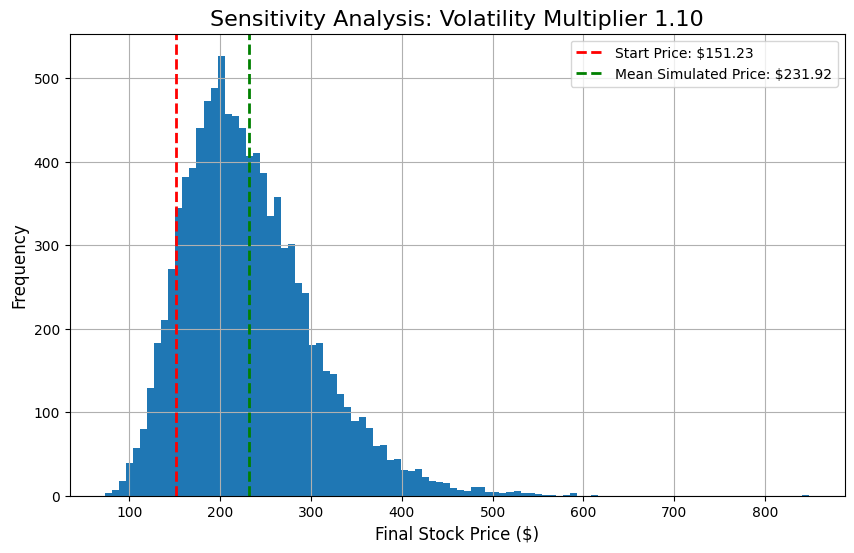

In [12]:
sensitivity_analysis('GOOG', '2024-03-31', num_simulations=10000, time_horizon=252, volatility_multiplier=1.1)

In [18]:
def validate_long_term_model(stock_list, validation_start_date, validation_end_date, history_years=5):

    model_training_end_date = pd.to_datetime(validation_start_date)
    model_training_start_date = model_training_end_date - pd.DateOffset(years=history_years)

    print(f"--- Validating for period: {validation_start_date} to {validation_end_date} ---")
    print(f"Using historical data from {model_training_start_date.date()} to {model_training_end_date.date()} to build the model...")

    model_data = yf.download(stock_list, start=model_training_start_date, end=model_training_end_date)['Close']
    if model_data.empty:
        print("Could not fetch sufficient historical data for the model.\n")
        return

    days_in_period = len(yf.download(stock_list, start=validation_start_date, end=validation_end_date)['Close'])

    portfolio_returns_simulation = run_simulation_for_validation(model_data, days_to_simulate=days_in_period)

    lower_bound = np.percentile(portfolio_returns_simulation, 2.5)
    upper_bound = np.percentile(portfolio_returns_simulation, 97.5)

    actual_data = yf.download(stock_list, start=validation_start_date, end=validation_end_date)['Close']
    num_stocks = len(stock_list)
    portfolio_weights = np.array([1/num_stocks] * num_stocks)

    initial_prices = actual_data.iloc[0].values
    final_prices = actual_data.iloc[-1].values

    initial_portfolio_value = np.sum(initial_prices * portfolio_weights)
    final_portfolio_value = np.sum(final_prices * portfolio_weights)

    actual_return = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value
    is_within_interval = lower_bound <= actual_return <= upper_bound

    print(f"\nSimulated 95% Confidence Interval for Return: [{lower_bound:.2%}, {upper_bound:.2%}]\n")
    print(f"\nActual Portfolio Return: {actual_return:.2%}\n")
    print(f"\nDid the actual return fall within the interval? {'Yes' if is_within_interval else 'No'}\n")
    print("-" * 50 + "\n")

    return is_within_interval

def run_simulation_for_validation(historical_data, days_to_simulate=252, num_simulations=10000):
    daily_returns = historical_data.pct_change().dropna()
    cov_matrix = daily_returns.cov()
    cholesky_decomp = np.linalg.cholesky(cov_matrix)
    start_prices = historical_data.iloc[-1].values
    portfolio_simulations = portfolio_monte_carlo(daily_returns, cholesky_decomp, start_prices, days_to_simulate, num_simulations)

    num_stocks = len(start_prices)
    portfolio_weights = np.array([1/num_stocks] * num_stocks)
    initial_portfolio_value = np.sum(start_prices * portfolio_weights)
    final_simulated_prices = portfolio_simulations[-1, :, :]
    final_simulated_portfolio_values = np.sum(final_simulated_prices * portfolio_weights, axis=1)

    portfolio_returns = (final_simulated_portfolio_values - initial_portfolio_value) / initial_portfolio_value
    return portfolio_returns



In [17]:
stock_list = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']


validate_long_term_model(stock_list, '2021-01-01', '2022-01-01')
validate_long_term_model(stock_list, '2022-01-01', '2023-01-01')
validate_long_term_model(stock_list, '2023-01-01', '2024-01-01')

/tmp/ipython-input-2664496750.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  model_data = yf.download(stock_list, start=model_training_start_date, end=model_training_end_date)['Close']
[**********************57%**                     ]  4 of 7 completed

--- Validating for period: 2021-01-01 to 2022-01-01 ---
Using historical data from 2016-01-01 to 2021-01-01 to build the model...


[*********************100%***********************]  7 of 7 completed
/tmp/ipython-input-2664496750.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  days_in_period = len(yf.download(stock_list, start=validation_start_date, end=validation_end_date)['Close'])
[*********************100%***********************]  7 of 7 completed
/tmp/ipython-input-2664496750.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  actual_data = yf.download(stock_list, start=validation_start_date, end=validation_end_date)['Close']
[*********************100%***********************]  7 of 7 completed
/tmp/ipython-input-2664496750.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  model_data = yf.download(stock_list, start=model_training_start_date, end=model_training_end_date)['Close']
[**********************57%**                     ]  4 of 7 completed


Simulated 95% Confidence Interval for Return: [-17.28%, 154.08%]


Actual Portfolio Return: 38.27%


Did the actual return fall within the interval? Yes

--------------------------------------------------

--- Validating for period: 2022-01-01 to 2023-01-01 ---
Using historical data from 2017-01-01 to 2022-01-01 to build the model...


[*********************100%***********************]  7 of 7 completed
/tmp/ipython-input-2664496750.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  days_in_period = len(yf.download(stock_list, start=validation_start_date, end=validation_end_date)['Close'])
[*********************100%***********************]  7 of 7 completed
/tmp/ipython-input-2664496750.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  actual_data = yf.download(stock_list, start=validation_start_date, end=validation_end_date)['Close']
[*********************100%***********************]  7 of 7 completed
/tmp/ipython-input-2664496750.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  model_data = yf.download(stock_list, start=model_training_start_date, end=model_training_end_date)['Close']
[********************* 43%                       ]  3 of 7 completed


Simulated 95% Confidence Interval for Return: [-13.27%, 191.95%]


Actual Portfolio Return: -50.01%


Did the actual return fall within the interval? No

--------------------------------------------------

--- Validating for period: 2023-01-01 to 2024-01-01 ---
Using historical data from 2018-01-01 to 2023-01-01 to build the model...


[*********************100%***********************]  7 of 7 completed
/tmp/ipython-input-2664496750.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  days_in_period = len(yf.download(stock_list, start=validation_start_date, end=validation_end_date)['Close'])
[*********************100%***********************]  7 of 7 completed
/tmp/ipython-input-2664496750.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  actual_data = yf.download(stock_list, start=validation_start_date, end=validation_end_date)['Close']
[*********************100%***********************]  7 of 7 completed


Simulated 95% Confidence Interval for Return: [-33.99%, 154.00%]


Actual Portfolio Return: 93.03%


Did the actual return fall within the interval? Yes

--------------------------------------------------



np.True_

In [19]:

def portfolio_monte_carlo(daily_returns, cholesky_decomp, start_prices, days, num_simulations):
    num_stocks = len(start_prices)
    simulation_results = np.zeros((days, num_simulations, num_stocks))
    simulation_results[0, :, :] = start_prices

    mean_returns = daily_returns.mean().values
    variances = daily_returns.var().values
    drift = mean_returns - (0.5 * variances)

    for i in range(1, days):
        uncorrelated_random = np.random.normal(0, 1, (num_simulations, num_stocks))
        correlated_random = uncorrelated_random @ cholesky_decomp.T
        simulated_daily_returns = np.exp(drift + correlated_random)
        simulation_results[i, :, :] = simulation_results[i-1, :, :] * simulated_daily_returns

    return simulation_results


def run_portfolio_simulation(historical_data, days_to_simulate=21, num_simulations=1000):
    daily_returns = historical_data.pct_change().dropna()
    if daily_returns.empty:
        return 0

    cov_matrix = daily_returns.cov()
    cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6

    cholesky_decomp = np.linalg.cholesky(cov_matrix)
    start_prices = historical_data.iloc[-1].values

    portfolio_simulations = portfolio_monte_carlo(daily_returns, cholesky_decomp, start_prices, days_to_simulate, num_simulations)

    num_stocks = len(start_prices)
    portfolio_weights = np.array([1/num_stocks] * num_stocks)
    initial_portfolio_value = np.sum(start_prices * portfolio_weights)

    final_simulated_prices = portfolio_simulations[-1, :, :]
    final_simulated_portfolio_values = np.sum(final_simulated_prices * portfolio_weights, axis=1)

    portfolio_returns = (final_simulated_portfolio_values - initial_portfolio_value) / initial_portfolio_value

    var_95 = np.percentile(portfolio_returns, 5)
    return var_95

In [23]:
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

def run_backtest(stock_list, start_date, end_date, var_threshold=-0.10, history_years=5):
    print("--- Starting Backtest for VaR Threshold Strategy ---")

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    all_data = yf.download(stock_list, start=start_date - pd.DateOffset(years=history_years), end=end_date, progress=False)['Close']

    backtest_dates = pd.date_range(start=start_date, end=end_date, freq='MS') # 'MS' for Month Start

    strategy_returns = []
    buy_and_hold_returns = []

    current_date = start_date
    for next_month_start in backtest_dates:

        model_training_end_date = current_date
        model_training_start_date = model_training_end_date - pd.DateOffset(years=history_years)
        model_data = all_data.loc[model_training_start_date:model_training_end_date]

        if model_data.empty or len(model_data) < 20:
            current_date = next_month_start
            strategy_returns.append(0)
            continue

        one_month_var = run_portfolio_simulation(model_data, days_to_simulate=21)

        month_data = all_data.loc[current_date:next_month_start]

        if len(month_data) < 2:
            current_date = next_month_start
            strategy_returns.append(0)
            buy_and_hold_returns.append(0)
            continue

        num_stocks = len(stock_list)
        portfolio_weights = np.array([1/num_stocks] * num_stocks)
        initial_prices = month_data.iloc[0].values
        final_prices = month_data.iloc[-1].values
        initial_portfolio_value = np.sum(initial_prices * portfolio_weights)
        final_portfolio_value = np.sum(final_prices * portfolio_weights)
        actual_monthly_return = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value
        buy_and_hold_returns.append(actual_monthly_return)

        if one_month_var < var_threshold:
            strategy_returns.append(0)
            print(f"{current_date.date()}: VaR is {one_month_var:.2%}. Risk too high. Moving to cash.")
        else:
            strategy_returns.append(actual_monthly_return)
            print(f"{current_date.date()}: VaR is {one_month_var:.2%}. Staying invested.")

        current_date = next_month_start


    results_df = pd.DataFrame({
        'Date': backtest_dates[:len(strategy_returns)],
        'Strategy_Return': strategy_returns,
        'Buy_and_Hold_Return': buy_and_hold_returns
    }).set_index('Date')


    results_df['Strategy_Cumulative'] = (1 + results_df['Strategy_Return']).cumprod()
    results_df['Buy_and_Hold_Cumulative'] = (1 + results_df['Buy_and_Hold_Return']).cumprod()

    total_return_strategy = results_df['Strategy_Cumulative'].iloc[-1] - 1
    total_return_bnh = results_df['Buy_and_Hold_Cumulative'].iloc[-1] - 1

    print("\n--- Backtest Results ---")
    print(f"Total Return (VaR Strategy): {total_return_strategy:.2%}")
    print(f"Total Return (Buy and Hold): {total_return_bnh:.2%}")

    plt.figure(figsize=(14, 8))
    plt.plot(results_df.index, results_df['Strategy_Cumulative'], label='VaR Threshold Strategy')
    plt.plot(results_df.index, results_df['Buy_and_Hold_Cumulative'], label='Buy and Hold')
    plt.title('Backtest Performance Comparison')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results_df

--- Starting Backtest for VaR Threshold Strategy ---


/tmp/ipython-input-1909721330.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(stock_list, start=start_date - pd.DateOffset(years=history_years), end=end_date, progress=False)['Close']


2020-01-01: VaR is -7.31%. Staying invested.
2020-02-01: VaR is -7.37%. Staying invested.
2020-03-01: VaR is -7.98%. Staying invested.
2020-04-01: VaR is -8.62%. Staying invested.
2020-05-01: VaR is -9.08%. Staying invested.
2020-06-01: VaR is -8.85%. Staying invested.
2020-07-01: VaR is -9.51%. Staying invested.
2020-08-01: VaR is -9.01%. Staying invested.
2020-09-01: VaR is -8.60%. Staying invested.
2020-10-01: VaR is -9.14%. Staying invested.
2020-11-01: VaR is -8.66%. Staying invested.
2020-12-01: VaR is -9.89%. Staying invested.
2021-01-01: VaR is -9.79%. Staying invested.
2021-02-01: VaR is -9.42%. Staying invested.
2021-03-01: VaR is -9.43%. Staying invested.
2021-04-01: VaR is -9.94%. Staying invested.
2021-05-01: VaR is -9.51%. Staying invested.
2021-06-01: VaR is -9.36%. Staying invested.
2021-07-01: VaR is -9.03%. Staying invested.
2021-08-01: VaR is -8.44%. Staying invested.
2021-09-01: VaR is -9.21%. Staying invested.
2021-10-01: VaR is -9.24%. Staying invested.
2021-11-01

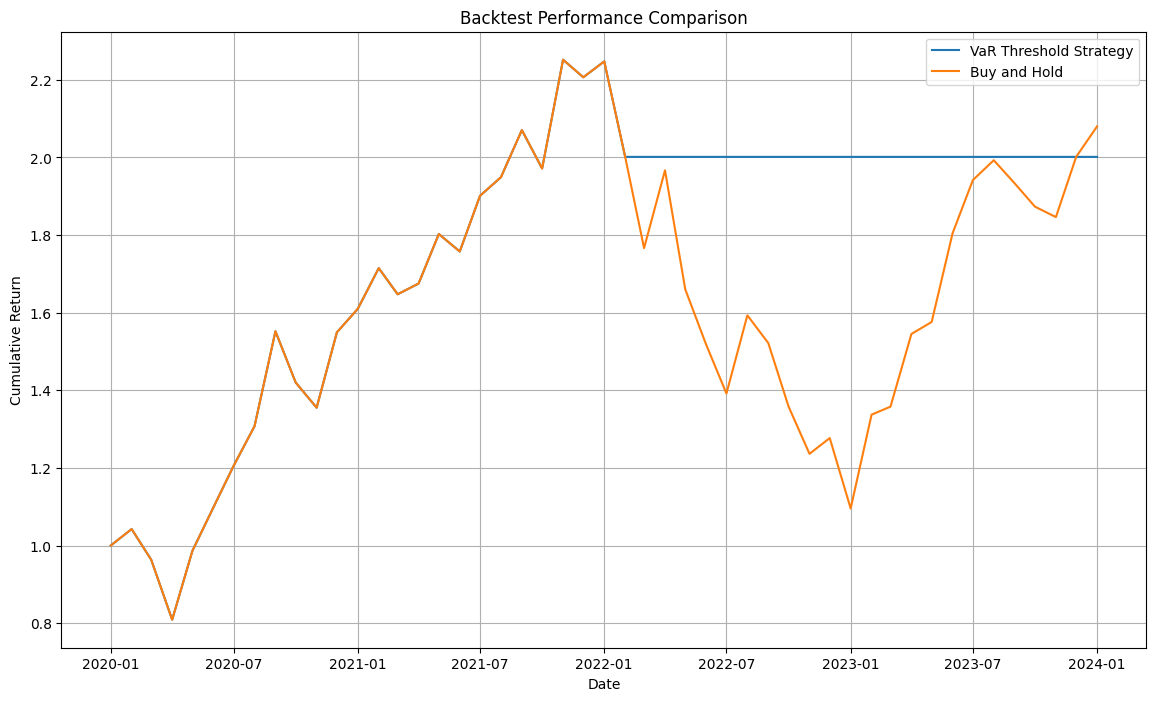

In [24]:
stock_list = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']


backtest_results = run_backtest(stock_list, start_date='2020-01-01', end_date='2024-01-01', var_threshold=-0.10)